In [509]:
import warnings
warnings.filterwarnings('ignore')
import numpy
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn import cross_validation
import matplotlib.pyplot as plt


# Word2Vec function by gensim models

In [104]:
import gensim.models
import logging

def Word2Vec(vector_size,training_alg):
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    model = gensim.models.Word2Vec(size = vector_size,sg=training_alg)
    sentences = gensim.models.word2vec.LineSentence("reviews_all_2306.txt")
    model.build_vocab(sentences,total_examples=len(sentences))
    model.train(sentences)

    return model

# Dataset Import Function

In [417]:
def FromExcelToArray():

    WBook = xlrd.open_workbook("ReviewsAndRatings_all_19_06.xls")
    WSheets = WBook.sheets()
    ReviewWS,RatingsWS = WSheets


    Ratings = RatingsWS.col_values(0)
    Reviews = ReviewWS.col_values(0)
    Ratings_Normal = RatingsWS.col_values(1)

    return Ratings,Reviews,Ratings_Normal


In [418]:
Ratings,Reviews,_ = FromExcelToArray()
sentences = []
for review in Reviews:
    sentences.append(review.split())

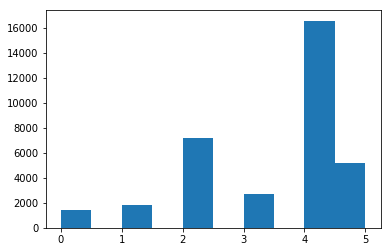

In [512]:
#Ranking distribution of the reviews
plt.hist(np.round(Ratings));
plt.show()

# W2V Model Generation

In [108]:
model = gensim.models.Word2Vec(sentences)

2018-10-06 13:55:29,605 : INFO : collecting all words and their counts
2018-10-06 13:55:29,609 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-10-06 13:55:29,753 : INFO : PROGRESS: at sentence #10000, processed 377787 words, keeping 49936 word types
2018-10-06 13:55:29,896 : INFO : PROGRESS: at sentence #20000, processed 849752 words, keeping 82778 word types
2018-10-06 13:55:30,017 : INFO : PROGRESS: at sentence #30000, processed 1222645 words, keeping 103818 word types
2018-10-06 13:55:30,083 : INFO : collected 112561 word types from a corpus of 1404677 raw words and 34991 sentences
2018-10-06 13:55:30,084 : INFO : Loading a fresh vocabulary
2018-10-06 13:55:30,202 : INFO : effective_min_count=5 retains 21447 unique words (19% of original 112561, drops 91114)
2018-10-06 13:55:30,203 : INFO : effective_min_count=5 leaves 1269948 word corpus (90% of original 1404677, drops 134729)
2018-10-06 13:55:30,296 : INFO : deleting the raw counts dictionary of 112

# Rev2Vec 

Imported reviews and ratings are processed to convert vector representation. rev2vec is average of vector representation of the review sentences.

In [485]:
rev2vec = np.zeros((100,34900))
rat2vec = np.zeros((1,34900))
temp = np.zeros((100,1))
count = 1

for sentence in sentences:
    vectorSize = 0
    for word in sentence:
        try:
            temp += np.reshape(model[word],(100,1))
            vectorSize += 1
        except KeyError:
            continue
    if vectorSize > 0:
        temp /= vectorSize
        rev2vec[:,count-1:count] = temp
        rat2vec[:,count-1:count] = Ratings[count-1]
        count += 1

# Train and test set

In [442]:
train_rev,test_rev,train_rat,test_rat = cross_validation.train_test_split(rev2vec.T,rat2vec.T,test_size = 0.2)




# Classification for Ranking Prediction

Different kernel performance is observed

In [443]:
svm_model = svm.SVC(kernel = 'rbf')
svm_model.fit(train_rev,np.round(train_rat))
svm_model.score(test_rev,np.round(test_rat))

0.47449856733524354

In [445]:
svm_model = svm.SVC(kernel = 'linear')
svm_model.fit(train_rev,np.round(train_rat))
svm_model.score(test_rev,np.round(test_rat))

0.47449856733524354

In [447]:
svm_model2 = svm.LinearSVC()
svm_model2.fit(train_rev,np.round(train_rat))
svm_model2.score(test_rev,np.round(test_rat))

0.47392550143266476

In [ ]:
clf = MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(100, 50,1), random_state=1)
clf.fit(train_rev.T,np.round(train_rat.T))


# Classification for Sentiment Prediction

In [486]:
#Rating greater than 2.5 is assigned to positive (1), others to negative(0)
rat2vec = np.reshape(rat2vec,(34900))
y = rat2vec
y[rat2vec <= 2.5] = 0
y[rat2vec > 2.5] = 1

In [501]:
train_rev,test_rev,train_rat,test_rat = cross_validation.train_test_split(rev2vec.T,y,test_size = 0.2)


In [502]:
svm_model = svm.SVC(kernel = 'rbf')
svm_model.fit(train_rev,train_rat)
svm_model.score(test_rev,test_rat)

0.7041547277936963

In [503]:
svm_model2 = svm.LinearSVC()
svm_model2.fit(train_rev,np.round(train_rat))
svm_model2.score(test_rev,np.round(test_rat))

0.7064469914040115

In [504]:
clf = MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(50,10), random_state=1)
clf.fit(train_rev,np.round(train_rat))
clf.score(test_rev,np.round(test_rat))

0.6936962750716332

In [505]:
train_rev = rev2vec.T[:10000,:]
train_rat = y[:10000]
test_rev = rev2vec.T[10000:12000,:]
test_rat = y[10000:12000]

In [506]:
svm_model = svm.SVC(kernel = 'rbf')
svm_model.fit(train_rev,train_rat)
svm_model.score(test_rev,test_rat)

0.755

In [507]:
svm_model2 = svm.LinearSVC()
svm_model2.fit(train_rev,np.round(train_rat))
svm_model2.score(test_rev,np.round(test_rat))

0.764

In [508]:
clf = MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(50,10), random_state=1)
clf.fit(train_rev,np.round(train_rat))
clf.score(test_rev,np.round(test_rat))

0.756